In [103]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from datetime import datetime

In [126]:
# --- Carica dati e modello ---

TICKER = "ORCL"

df = pd.read_csv(
    f"csv/{TICKER}_indicators.csv",
    index_col=0,
    parse_dates=[0],
    date_format="ISO8601"
)

bundle = joblib.load(f"models/rf_{TICKER}_v1.joblib")

rf = bundle["model"]
features = bundle["features"]

In [127]:
# Simulation parameters
# create an explicit copy to avoid SettingWithCopyWarning
testdata = df.loc[df.index > "2025-08-31"].copy()
starting_cash = 1000

Soldi di partenza: 1000 | Soldi alla fine 1270.0399945520774 | Guadagno 27.004 %


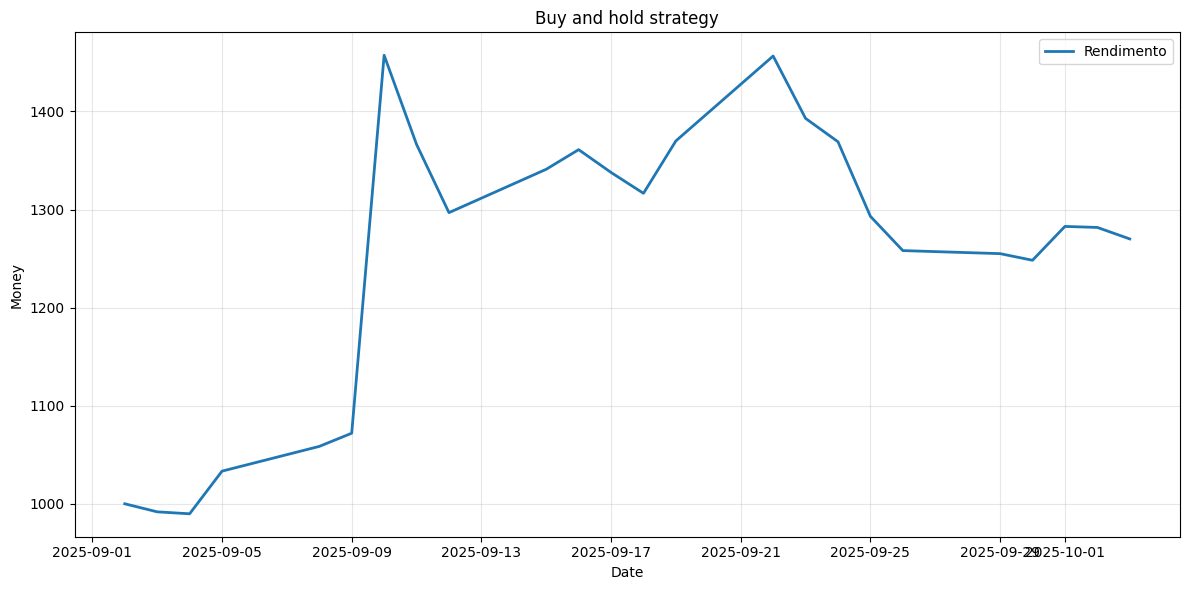

In [128]:
# Baseline trading stategy: buy and hold
number_of_actions = starting_cash / testdata.iloc[0]["Close"]
payout = number_of_actions * testdata.iloc[-1]["Close"]

print(f"Soldi di partenza: {starting_cash} | Soldi alla fine {payout} | Guadagno {((payout - starting_cash)/starting_cash) * 100:.3f} %")

plt.figure(figsize=(12,6))
plt.plot(testdata.index, (testdata["Close"] *  number_of_actions), label='Rendimento', color='#1f77b4', linewidth=2)
plt.title("Buy and hold strategy")
plt.xlabel("Date")
plt.ylabel("Money")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Soldi di partenza: 1000 | Soldi alla fine 1028.3759291206852 | Guadagno 2.838 %


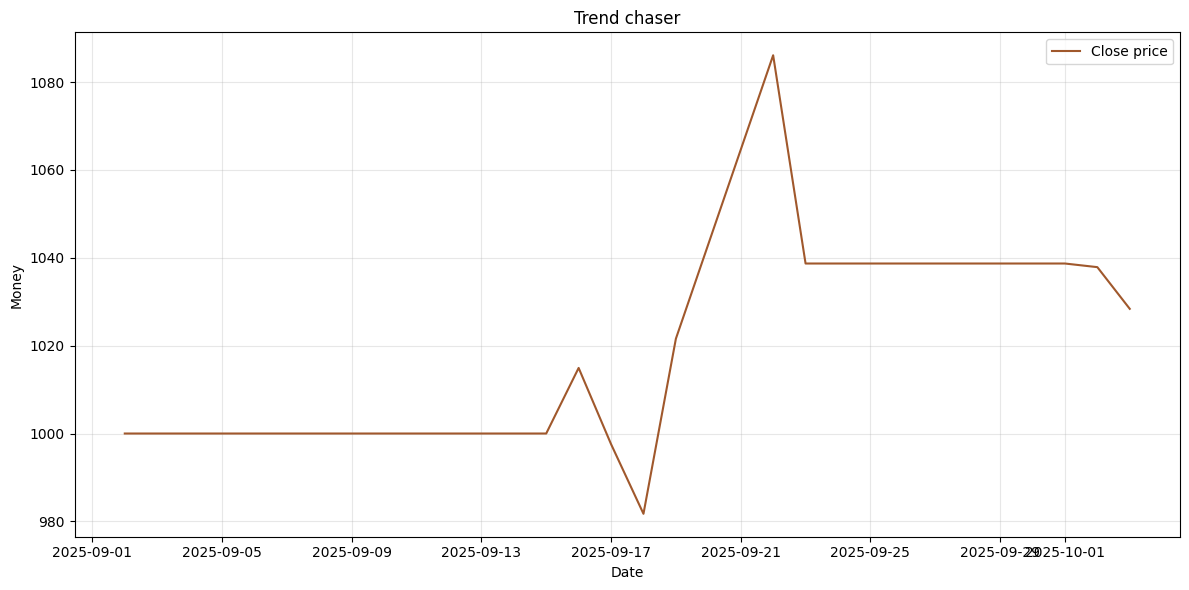

In [129]:
# Second baseline: trend chaser (apply-based)
state = {
    "cash": starting_cash,
    "shares": 0.0,
    "prev_price": None,
    "streak": 0,
    "trashold": 3
}

def step(row):
    price = float(row["Close"])
    prev = state["prev_price"]

    # initialize on first row
    if prev is None:
        state["prev_price"] = price
        portfolio = state["cash"] + state["shares"] * price
        return portfolio

    # replicate the original decision logic
    if state["shares"] <= 0:
        # bear
        if prev > price:
            state["streak"] += 1
        else:
            if state["streak"] >= state["trashold"]:
                # original code added more shares using all cash
                state["shares"] += state["cash"] / price
                state["cash"] = 0.0
                state["streak"] = 0
    else:
        # Bull
        if prev <= price:
            state["streak"] += 1
        else:
            if state["streak"] >= state["trashold"]:
                # original code sold shares (though shares==0 here in original), keep same behaviour
                state["cash"] += state["shares"] * price
                state["shares"] = 0.0
                state["streak"] = 0

    state["prev_price"] = price
    portfolio = state["cash"] + state["shares"] * price

    # Debug print
    #print(f"data : {row.name.strftime("%Y-%m-%d")} | shares : {state['shares']} | cash: {state['cash']} | price : {("Bear" if (state["prev_price"] > price) else "Bull")} | {state["streak"]}")

    return portfolio

# apply the function row-wise; apply executes in index order
testdata.loc[:, "portfolio_value"] = testdata.apply(step, axis=1)

# final payout following the same formula used previously
payout = state["cash"] + (state["shares"] * testdata.iloc[-1]["Close"])

print(f"Soldi di partenza: {starting_cash} | Soldi alla fine {payout} | Guadagno {((payout - starting_cash)/starting_cash) * 100:.3f} %")


plt.figure(figsize=(12,6))
#plt.plot(testdata.index, testdata["portfolio_value"], label='Portfolio value (trend chaser)', color='#2ca02c')
plt.plot(testdata.index, testdata["portfolio_value"], label='Close price', color="#a0582c")
plt.title('Trend chaser')
plt.xlabel('Date')
plt.ylabel('Money')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Soldi di partenza: 1000 | Soldi alla fine 1229.1237581505561 | Guadagno 22.912 %


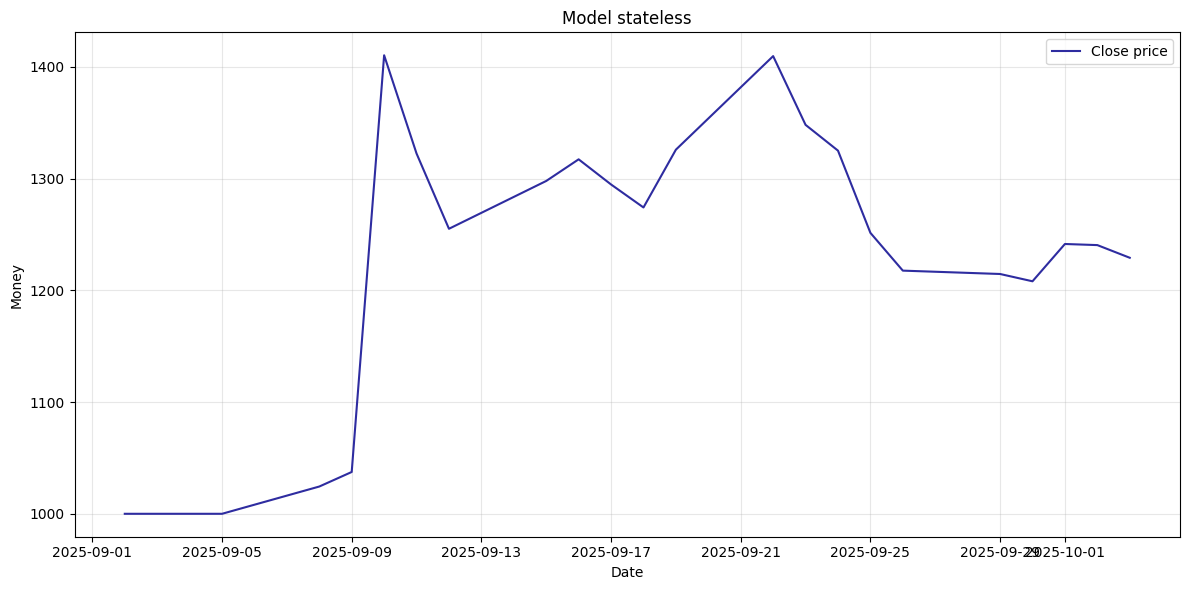

In [130]:
# Statless model action
Y = rf.predict(testdata[features])

# assign into testdata explicitly using .loc to avoid SettingWithCopyWarning
testdata.loc[:, "model_action"] = Y

state = {
    "cash": starting_cash,
    "shares": 0.0
}

def model_action(row):
    price = float(row["Close"])
    action = row["model_action"]


    if action == 'BUY':
        if state["cash"] > 0:
            state["shares"] = state["cash"] / price 
            state["cash"] = 0
    elif action == 'SELL':
        if state["shares"] > 0:
            state["cash"] = state["shares"] * price
            state["shares"] = 0.0

    #print(f" date: {row.name.strftime("%Y-%m-%d")} | signal : {action} | cash: {state["cash"]} | shares: {state["shares"]}")
    return state["cash"] + state["shares"] * price

# assign results explicitly with .loc
testdata.loc[:, "model_value"] = testdata.apply(model_action, axis=1)

# final payout following the same formula used previously
payout = state["cash"] + (state["shares"] * testdata.iloc[-1]["Close"])

print(f"Soldi di partenza: {starting_cash} | Soldi alla fine {payout} | Guadagno {((payout - starting_cash)/starting_cash) * 100:.3f} %")


plt.figure(figsize=(12,6))
plt.plot(testdata.index, testdata["model_value"], label='Close price', color="#2e2ca0")
plt.title('Model stateless')
plt.xlabel('Date')
plt.ylabel('Money')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

|Ticker|Baseline 1|Baseline 2| Model|
|---|---|---|---|
|AAPL|12.319%|4.789%|**3.637%**|
|META|-3.340%|0.680%|**-3.156%**|
|MSFT|2.421%|-0.423%|**0.534%**|
|ORCL|27.004%|2.838%|**22.913%**|